# Data Analysis of Healthcare Company\`s Finance 

This demostration is to help group healthcare-related company based on their financial health. In doing so, we hope to achieve reasonable groupings that could tell us how well a company is doing compared to other companies of the same sector as well as the past performance of the sector. We hope that this could be useful to better reccomend project that are suitable to their financial positions.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from minisom import MiniSom
import matplotlib.pyplot as plt
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from hyperopt import hp, tpe, fmin
import pickle
from bokeh.io import output_file, output_notebook, curdoc
from bokeh.plotting import figure, show
from bokeh.palettes import inferno,viridis
from bokeh.models import ColumnDataSource, HoverTool, CustomJS, Circle, Panel, Tabs
from bokeh.layouts import column
from bokeh.models.widgets import CheckboxGroup
from yellowbrick.cluster import KElbowVisualizer

%matplotlib inline
output_notebook()

Loading BokehJS ...

## Data Inputation

Here, we try to decide on the kind of ratio to use for the classifications provided from SGX to perform the classification. We priortise profit-based ratios as the key indicator whether a company is doing very well while giving considerations to some of the rest.

In [2]:
df = pd.read_csv('assets/healthcare_sgx.csv')

In [3]:
df.set_index(['year','company'],inplace=True)

In [4]:
# keeping only ratios
# 4 profit, 1 efficency, 2 liquidity, 1 leverage
ratios = ['Return on Assets (ROA)','Return on Equity (ROE)','Operating Margin','Net Profit Margin','Asset Turnover',
                  'Current Ratio','Quick Ratio','Debt / Equity']

In [5]:
# limiting the dataset to only the ratios
df = df[ratios]

In [6]:
# casting all the data from string to numeric and input NaN to data that cannot be casted
df = df.apply(pd.to_numeric, errors='coerce')

In [7]:
df.isnull().sum()

Return on Assets (ROA)    33
Return on Equity (ROE)    38
Operating Margin           1
Net Profit Margin          2
Asset Turnover            34
Current Ratio              0
Quick Ratio                0
Debt / Equity             37
dtype: int64

In [8]:
# some companies no debt and is conservative, choice of zero seems fair
df['Debt / Equity'].fillna(0,inplace=True)

In [9]:
# drop rows with ROA,ROE and Asset Turnover (missing due to sgx data only kept for 5 year)
df.dropna(axis=0,inplace=True)

In [10]:
df.isnull().sum()

Return on Assets (ROA)    0
Return on Equity (ROE)    0
Operating Margin          0
Net Profit Margin         0
Asset Turnover            0
Current Ratio             0
Quick Ratio               0
Debt / Equity             0
dtype: int64

In [11]:
len(df)

122

In [12]:
df.sort_index(axis=0)

Return on Assets (ROA)  Return on Equity (ROE)  \
year company                                                            
2016 Aoxin Q & M                        0.026                   0.026   
     AsiaMedic                         -0.077                  -0.127   
     Asian Healthcare                   0.534                   2.188   
     Clearbridge                       -0.068                  -0.055   
     Cordlife                           0.042                   0.084   
...                                       ...                     ...   
2019 Vicplas Intl                       0.054                   0.071   
     Yunnan Energy                     -0.038                  -0.068   
2020 HC Surgical                        0.142                   0.194   
     Medinex                            0.240                   0.262   
     UG Healthcare                      0.142                   0.283   

                       Operating Margin  Net Profit Margin  Asset Turnover  \
year company                                                                 
2016 Aoxin Q & M                  0.158              0.089           0.297   
     AsiaMedic                   -0.099             -0.079           0.973   
     Asian Healthcare             0.201              0.186           2.868   
     Clearbridge                -16.389            -23.937           0.003   
     Cordlife                     0.106              0.211           0.198   
...                                 ...                ...             ...   
2019 Vicplas Intl                 0.054              0.052           1.025   
     Yunnan Energy               -0.020             -0.064           0.591   
2020 HC Surgical                  0.345              0.242           0.587   
     Medinex                      0.271              0.245           0.981   
     UG Healthcare                0.131              0.105           1.360   

                       Current Ratio  Quick Ratio  Debt / Equity  
year company                                                      
2016 Aoxin Q & M               0.639        0.578          0.000  
     AsiaMedic                 1.525        1.476          0.224  
     Asian Healthcare          1.497        1.497          0.000  
     Clearbridge               1.142        1.142          0.000  
     Cordlife                  5.007        4.974          0.607  
...                              ...          ...            ...  
2019 Vicplas Intl              2.271        1.786          0.148  
     Yunnan Energy            11.066        9.832          0.695  
2020 HC Surgical               2.043        1.936          0.475  
     Medinex                   2.646        2.389          0.135  
     UG Healthcare             1.495        0.832          0.683  

[122 rows x 8 columns]

## Visualisation

In [13]:
df_no_index=df.reset_index()

In [14]:
# all companies
companies = list(df_no_index.company.unique())

In [38]:
def create_figure(i):
    fig = figure(title=i,x_axis_label='Year', y_axis_label='Ratios',y_axis_type="log",tools="pan,box_select",plot_width=900, plot_height=900,toolbar_location="above")
    #  create a coloring for each of the 33 companies
    for color,company in zip(viridis(33),companies):
        # setting the dataset to use
        company_data=df_no_index[df_no_index.company==company]
        # create a trend line
        company_line=fig.line(source=company_data,x='year',y=i,legend_label=company,color=color)
        # hide the trend line by default
        company_line.visible=False
    # set a interactive legend outside graph
    fig.add_layout(fig.legend[0], 'left')
    fig.legend.click_policy="hide"
    # Hover tool with vline mode and cap it to 3 decimal place 0.000
    hover = HoverTool(tooltips=[(i, "@{" + i + "}{0.000}"),('Year','@year'),('Company', '@{company}')])
    fig.add_tools(hover)
    tab = Panel(child=fig,title=i)
    return tab

In [39]:
# creating the figures and showing them all
tab_list=[]
for i in ratios:
    tab_list.append(create_figure(i))

layout=Tabs(tabs=tab_list)
show(layout)

# Clustering

In [17]:
data = df.to_numpy()
# scaling the data to match
ss= StandardScaler()
transformed_data = ss.fit_transform(data)

## SOM

We can try to visualise the number of clusters using a Self-Organising Map (SOM).

In general, the size of the map is acknowledged to be 2D $5\times\sqrt{n}$ where $n$ is the number of dataset we have. This calculates to approximately an $8*8$ map. Our choice of neighbourhood is also based on estimations (cannot be above $n/2$ for convergence). The choice of learning rate will have to be optimize to reduce quantization error. Evolutions and iterations are estimated to be ~1000 times more than the size of the dataset but in our case the map seems to converge fairly well in about ~60000

In [18]:
# hyperparameter tuning for learning rate
som_shape = (8,8)
best_params = fmin(
    fn = lambda sig: MiniSom(som_shape[0],som_shape[1],8,sigma=sig,learning_rate=.5,random_seed=42).quantization_error(transformed_data),
    space = hp.uniform('sig', 0.01, 1),
    algo=tpe.suggest,
    max_evals=1000)
sigma = best_params['sig']

100%|███████████████████████████████████████████| 1000/1000 [00:05<00:00, 168.42trial/s, best loss: 1.6173453689417847]


In [19]:
# initialising 8*8 SOM map with pca-adjusted weights
som = MiniSom(som_shape[0],som_shape[1], 8, sigma=sigma,learning_rate=.5, random_seed = 42) 
som.pca_weights_init(transformed_data)
som.train(transformed_data, 60000)

In [20]:
# load weights used
with open('assets/som.p', 'rb') as infile:
    som = pickle.load(infile)

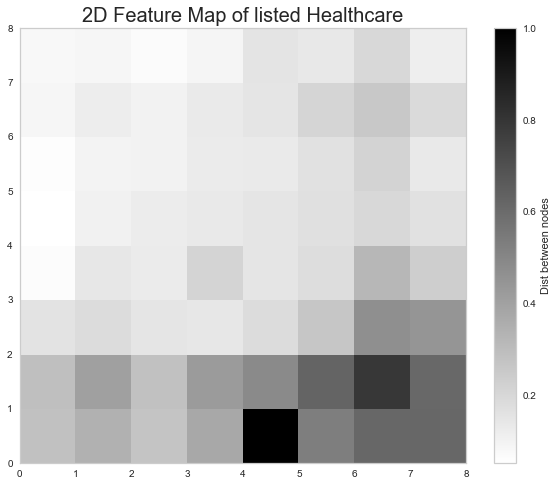

In [21]:
# plotting of the feature map obtained
plt.figure(figsize=(10,8))
plt.title('2D Feature Map of listed Healthcare',fontsize=20)
plt.pcolor(som.distance_map().T, cmap='binary') # plotting the distance map as background
plt.colorbar().set_label('Dist between nodes')

We would like if the number of clusters are easily observed where the nodes that are similar as seen below (the SOM for Iris dataset) but we unfortunately do not have such convenience. So we decided to go ahead with using the elbow K-Means method
Image adapted from :https://www.researchgate.net/figure/Iris-data-set-in-7-7-SOM-another-view-of-u-matrix-created-by-SOM-Toolbox_fig6_268205670

![title](assets/ideal_case.bmp)

## KMeans

Typically, the optimal number of clusters in KMeans is decided using the elbow method.

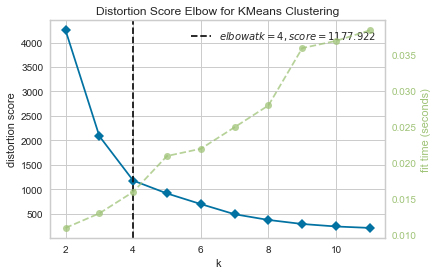

In [22]:
elbow = KMeans()
visualizer = KElbowVisualizer(elbow, k=(2,12))
visualizer.fit(data)
visualizer.show() 

In [23]:
# 3 clusters
kmean=KMeans(4,random_state=42)
kmean.fit_transform(transformed_data)
df['Kmeans']=kmean.predict(transformed_data)

In [24]:
df[df.Kmeans==0].describe()

,Return on Assets (ROA),Return on Equity (ROE),Operating Margin,Net Profit Margin,Asset Turnover,Current Ratio,Quick Ratio,Debt / Equity,Kmeans
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.0
mean,0.051258,0.120371,0.013165,-0.038309,0.757794,1.905691,1.620608,0.535969,0.0
std,0.176062,0.461783,0.494043,0.585013,0.573112,0.983297,0.929758,1.162235,0.0
min,-0.516000,-1.081000,-2.999000,-3.969000,0.025000,0.168000,0.167000,0.000000,0.0
25%,0.004000,0.007000,0.034000,0.003000,0.426000,1.258000,0.942000,0.055000,0.0
50%,0.047000,0.065000,0.096000,0.065000,0.578000,1.735000,1.476000,0.199000,0.0
75%,0.085000,0.157000,0.164000,0.143000,1.019000,2.496000,1.995000,0.623000,0.0
max,1.063000,2.365000,0.679000,0.620000,2.868000,4.316000,3.985000,8.798000,0.0


In [25]:
df[df.Kmeans==0].index[:]

MultiIndex([(2016,      'Aoxin Q & M'),
            (2017,      'Aoxin Q & M'),
            (2019,      'Aoxin Q & M'),
            (2017,      'Alliance HC'),
            (2018,      'Alliance HC'),
            (2019,      'Alliance HC'),
            (2016,        'AsiaMedic'),
            (2017,        'AsiaMedic'),
            (2018,        'AsiaMedic'),
            (2019,        'AsiaMedic'),
            (2016, 'Asian Healthcare'),
            (2017, 'Asian Healthcare'),
            (2018,      'Clearbridge'),
            (2019,      'Clearbridge'),
            (2017,         'Cordlife'),
            (2018,         'Cordlife'),
            (2019,         'Cordlife'),
            (2016,          'Haw Par'),
            (2017,          'Haw Par'),
            (2018,      'HC Surgical'),
            (2019,      'HC Surgical'),
            (2020,      'HC Surgical'),
            (2016,    'Healthway Med'),
            (2017,    'Healthway Med'),
            (2018,    'Healthway Med'),


In [26]:
# high liquidity cluster
df[df.Kmeans==1].describe()

,Return on Assets (ROA),Return on Equity (ROE),Operating Margin,Net Profit Margin,Asset Turnover,Current Ratio,Quick Ratio,Debt / Equity,Kmeans
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0
mean,0.099850,0.123700,0.011200,-0.031350,0.537200,7.095650,6.861850,0.084100,1.0
std,0.214777,0.266201,0.963362,0.938758,0.318853,2.243077,2.251392,0.198296,0.0
min,-0.404000,-0.473000,-3.340000,-3.345000,0.076000,4.425000,4.201000,0.000000,1.0
25%,0.031000,0.044500,0.081250,0.074750,0.195500,5.583750,5.377500,0.000000,1.0
50%,0.108000,0.119500,0.271500,0.214000,0.554000,6.333500,6.160500,0.002000,1.0
75%,0.242750,0.298250,0.547500,0.435000,0.763000,8.824000,8.539000,0.052500,1.0
max,0.509000,0.624000,0.803000,0.753000,1.177000,11.348000,11.348000,0.695000,1.0


In [27]:
# companies with high liquidity
df[df.Kmeans==1].index[:]

MultiIndex([(2018,      'Aoxin Q & M'),
            (2018, 'Asian Healthcare'),
            (2019, 'Asian Healthcare'),
            (2019,        'Biolidics'),
            (2016,         'Cordlife'),
            (2018,          'Haw Par'),
            (2019,          'Haw Par'),
            (2017,      'HC Surgical'),
            (2016,             'ISEC'),
            (2017,             'ISEC'),
            (2018,             'ISEC'),
            (2016,     'IX Biopharma'),
            (2017,     'IX Biopharma'),
            (2017,          'Medinex'),
            (2018,          'Medinex'),
            (2016,          'TalkMed'),
            (2017,          'TalkMed'),
            (2018,          'TalkMed'),
            (2019,          'TalkMed'),
            (2019,    'Yunnan Energy')],
           names=['year', 'company'])

In [28]:
# outlier
df[df.Kmeans==2]

,,Return on Assets (ROA),Return on Equity (ROE),Operating Margin,Net Profit Margin,Asset Turnover,Current Ratio,Quick Ratio,Debt / Equity,Kmeans
year,company,,,,,,,,,
2018,QT Vascular,1.411,14.369,2.692,2.649,0.533,2.278,2.093,0.135,2


In [29]:
# Research companies (next amazon)
df[df.Kmeans==3]

,,Return on Assets (ROA),Return on Equity (ROE),Operating Margin,Net Profit Margin,Asset Turnover,Current Ratio,Quick Ratio,Debt / Equity,Kmeans
year,company,,,,,,,,,
2016,Clearbridge,-0.068,-0.055,-16.389,-23.937,0.003,1.142,1.142,0.000,3
2017,Clearbridge,-0.137,-0.150,-37.000,-27.517,0.005,5.695,5.684,0.027,3
2018,IX Biopharma,-0.395,-0.535,-61.931,-62.142,0.006,3.381,3.307,0.211,3
2019,IX Biopharma,-0.443,-0.630,-19.773,-19.741,0.022,7.313,6.977,0.187,3


### SOM cluster

Attempting to see if the clustering method in SOM would be good in producing result

In [30]:
som4_shape = (1,4)
best_params = fmin(
    fn = lambda sig: MiniSom(som4_shape[0],som4_shape[1],8,sigma=sig,learning_rate=.5,random_seed=42).quantization_error(transformed_data),
    space = hp.uniform('sig', 0.01, 1),
    algo=tpe.suggest,
    max_evals=1000)
sigma = best_params['sig']
som4 = MiniSom(som4_shape[0],som4_shape[1], 8, sigma=sigma,learning_rate=.5, random_seed = 42) 
som4.pca_weights_init(transformed_data)
som4.train(transformed_data, 60000)

100%|███████████████████████████████████████████| 1000/1000 [00:04<00:00, 203.39trial/s, best loss: 2.0362705726011496]


C:\Users\user\Anaconda3\lib\site-packages\minisom.py:365: UserWarning: PCA initialization inappropriate:One of the dimensions of the map is 1.
  warn(msg)


In [31]:
# each neuron (eg 0,0) represents a cluster
winner_coordinates = np.array([som4.winner(x) for x in data]).T
print(winner_coordinates)
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som4_shape)
print(cluster_index)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 1 1 1 1 1 1 1 1 1 1 1 1 0 3 0 0 1 1 1 1
  1 0 1 1 2 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 1 1 1 1 1 1 1 1 1 1 1 1 0 3 0 0 1 1 1 1 1 0
 1 1 2 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]


In [32]:
# rename these index to be lower values from 0 to number of groupings
mapper=dict(zip(np.unique(cluster_index),range(len(np.unique(cluster_index)))))
mapper

{0: 0, 1: 1, 2: 2, 3: 3}

In [33]:
# append the groupings to dataframe
df['SOM4'] = [mapper[i] for i in cluster_index]

### SOM visualisation with KMeans/SOM grouping

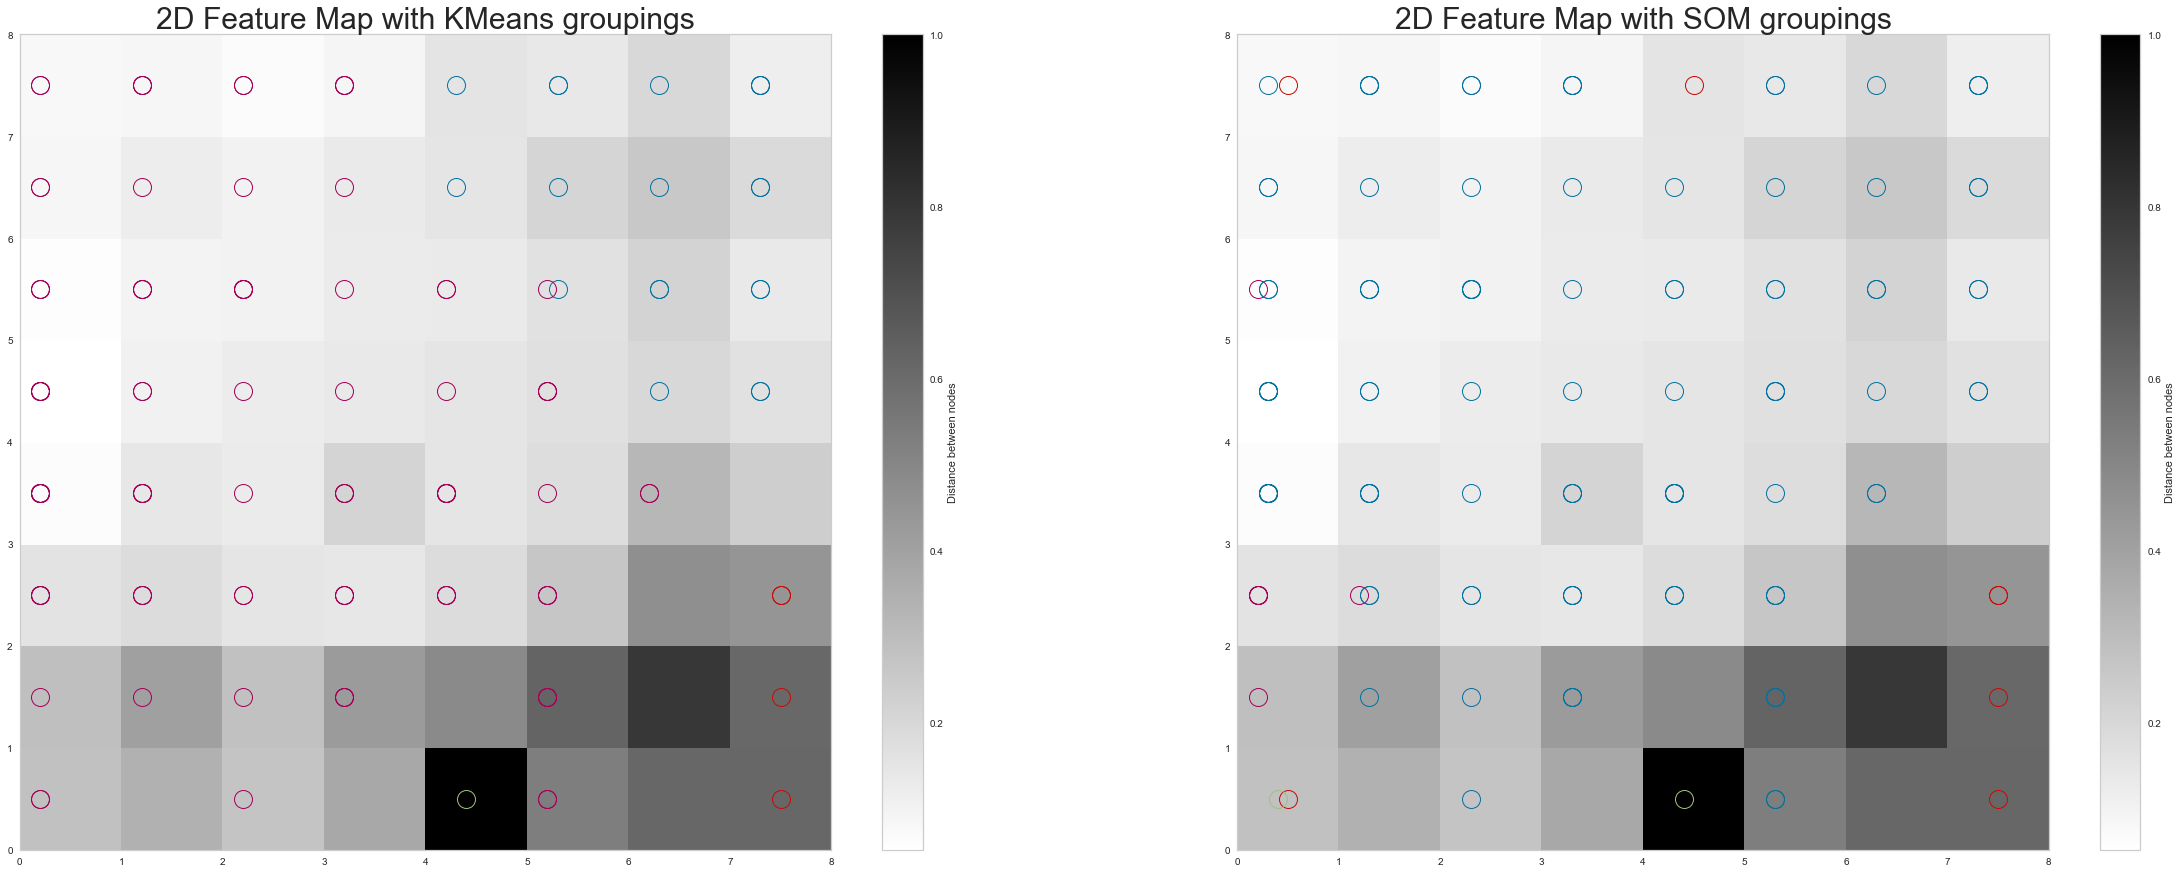

In [34]:
markers = ['.', ',', 'o', 's', 'p', 'h', 'H'] 
colors = ['C0', 'C1', 'C2','C3','C4','C5','C6','C7','C8','C9']
marker_size = [8,12,14,16,18,20,22]
offset = {0:.2,1:.3,2:.4,3:.5,4:.6,5:.7,6:.8}
plt.figure(figsize=(40,15))

plt.subplot(1, 2, 1)
plt.title('2D Feature Map with KMeans groupings',fontsize=30)
# plotting the distance map as background
plt.pcolor(som.distance_map().T, cmap='binary')
# colorbar to the side
plt.colorbar().set_label('Distance between nodes')
for cnt, xx in enumerate(transformed_data):
    w = som.winner(xx)  # getting the winner
    # place a marker on the winning position for the sample xx +.5 is to realign the matplotlib library
    # includes an offset based on cluster
    plt.plot(w[0]+offset[df.iloc[cnt,:]['Kmeans']], w[1]+.5, 'o', markerfacecolor='None',
             markeredgecolor=colors[df.Kmeans[cnt]-1], markersize=18, markeredgewidth=1)

plt.subplot(1, 2, 2)
plt.title('2D Feature Map with SOM groupings',fontsize=30)
# plotting the distance map as background
plt.pcolor(som.distance_map().T, cmap='binary')
# colorbar to the side
plt.colorbar().set_label('Distance between nodes')
for cnt, xx in enumerate(transformed_data):
    w = som.winner(xx)  # getting the winner
    # place a marker on the winning position for the sample xx +.5 is to realign the matplotlib library
    # includes an offset based on cluster
    plt.plot(w[0]+offset[df.iloc[cnt,:]['SOM4']], w[1]+.5, 'o', markerfacecolor='None',
             markeredgecolor=colors[df.SOM4[cnt]-1], markersize=18, markeredgewidth=1)

In [37]:
df.to_csv('assets/grouping.csv')

## Future Work

1) Ratios used should be more specific to the actual industry rather than sector. Eg. Hospital groups and Healthcare equipment supplier will have very different ratio since one is more service-oriented while the other goods-oriented.  
-- could scrap from description and use topic model to break down the industry

2) Longer time span for dataset

3) See if further groupings or different maps could have meaning assigned